# 因变量

In [1]:
import numpy as np

Ext = np.loadtxt('M_Oce_Er.txt', skiprows=1)[:, 1:]  # 目前使用的这一版截止时间为2020年2月
NINO3_4 =Ext[:-2, 4] # 所以选择数据时不选择最后两个月的数据，即不选择2020年1月和2020年2月的数据

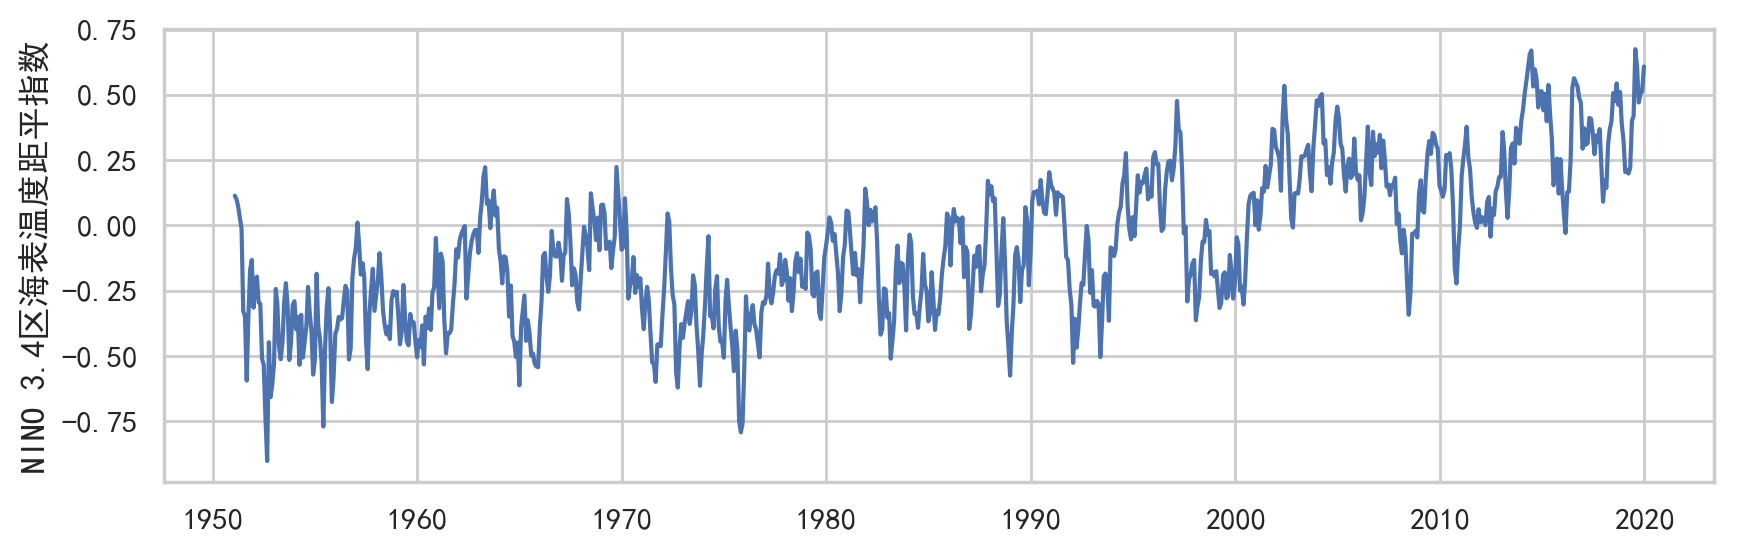

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

dates = pd.date_range("1 1 1951", periods=len(NINO3_4), freq="M")

plt.figure(figsize=(10, 3), dpi = 200)
plt.rcParams['axes.unicode_minus']=False
sns.set(style="whitegrid", font='SimHei')

plt.plot(np.array(dates), NINO3_4, 'b', linewidth=1.5)
plt.ylabel('NINO 3.4区海表温度距平指数')

plt.show()

# 自变量

In [4]:
import netCDF4

import numpy as np

from sklearn.decomposition import PCA

f = netCDF4.Dataset('sst.mnmean.nc') # 目前使用的这一版截止时间为2020年2月
'''
所以选择数据时不选择最后两个月的数据，即不选择2020年1月和2020年2月的数据
且因为ERSST v5数据集在1940s后才比较准确，所以选择1950年1月为数据起始，相对2020年2月偏移842个月
'''
SST = f.variables['sst'][-842:-2]
f.close()
print('数据结构：',np.shape(SST))

A = SST >= -2  # 1表示海洋，0表示陆地
n_ocean = np.average(A, axis = 0)
print('海洋所占栅格数目：%d'%np.sum(n_ocean))

数据结构： (840, 89, 180)
海洋所占栅格数目：10988


In [5]:
#距平
SST_new = np.copy(SST[A]).reshape(70, 12, 10988) # 年数*每年月数*栅格数
month_mean = np.average(SST_new[:60], axis=0) # 不同年份同一月份同一地点取均值
SST_anomaly = SST_new - month_mean
SST_anomaly = SST_anomaly.reshape(840, 10988)

# 建模

In [6]:
start_index = 12 # 1953年1月对应1951年1月偏移12个月

p = 1

X_model = np.zeros((828, 10988 * p))

for i in range(p):

    X_model[:, 10988 * i:10988 * (i + 1)] = SST_anomaly[start_index - i - 1: 840 - i - 1]

np.shape(X_model)

(828, 10988)

In [7]:
y_model = np.copy(NINO3_4)

np.shape(y_model)

(828,)

In [8]:
X_train = X_model[:-120]
y_train = y_model[:-120]
X_test = X_model[-120:]
y_test = y_model[-120:]

In [10]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import numpy as np

def NSE(true, fore):
    
    fore = fore.reshape(-1)
    true = true.reshape(-1)
    return 1 - np.sum((fore - true)**2) / np.sum((true - np.average(true))**2)

def evaluate(train, train_predict, test, test_predict):
    
    RMSE_train = mean_squared_error(train, train_predict)**0.5
    RMSE_test = mean_squared_error(test, test_predict)**0.5
    
    print('训练集RMSE：%0.3f'%RMSE_train)
    print('测试集RMSE：%0.3f'%RMSE_test)
    
    MAE_train  = mean_absolute_error(train, train_predict)
    MAE_test  = mean_absolute_error(test, test_predict)
        
    print('训练集MAE：%0.3f'%MAE_train)
    print('测试集MAE：%0.3f'%MAE_test)
    
    NSE_train  = NSE(train, train_predict)
    NSE_test  = NSE(test, test_predict)
    
    print('训练集NSE：%0.3f'%NSE_train)
    print('测试集NSE：%0.3f'%NSE_test)
    
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def draw_test(true, fore):
    
    dates = pd.date_range("1 1 2015", periods=120, freq="M")

    plt.figure(figsize=(10, 3), dpi = 200)
    plt.rcParams['axes.unicode_minus']=False
    sns.set(style="whitegrid", font='SimHei')
    
    plt.ylim(-1, 1)
    
    plt.plot(np.array(dates), true, 'b', linewidth=1.5, label='True')
    plt.plot(np.array(dates), fore, 'b--', linewidth=1.5, label='Fore')
    plt.ylabel('NINO 3.4区海表温度距平指数')
    plt.legend()
    plt.show()

# 线性模型

In [11]:
from sklearn import linear_model

reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

evaluate(y_train, train_predict, y_test, test_predict)

训练集RMSE：0.000
测试集RMSE：0.626
训练集MAE：0.000
测试集MAE：0.538
训练集NSE：1.000
测试集NSE：-9.305


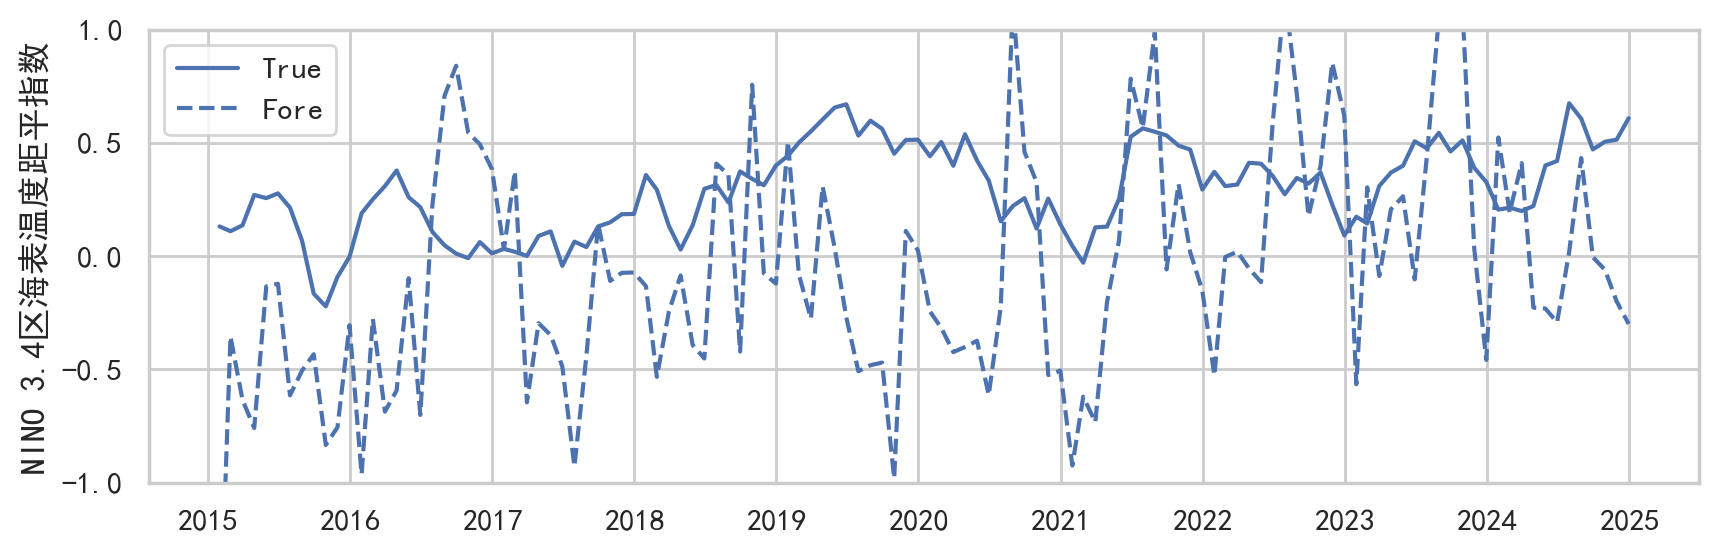

In [12]:
draw_test(y_test, test_predict)

# LASSO模型

In [16]:
import sklearn.model_selection as sk_model_selection

import warnings
warnings.filterwarnings("ignore")

for alpha in np.linspace(0.005, 0.010, 6):
    reg = linear_model.Lasso(alpha=alpha, max_iter=10000)
    print('%0.3f'%alpha, abs(np.mean(sk_model_selection.cross_val_score(reg, X_train, y_train, scoring='neg_mean_squared_error', cv = 10)))**0.5)

0.005 0.1455990659810886
0.006 0.14523456055811576
0.007 0.14515516877465973
0.008 0.14543943907864101
0.009 0.1457999059802132
0.010 0.14654817464759995


In [17]:
from sklearn import linear_model

reg = linear_model.Lasso(alpha=0.007, max_iter=10000)
reg.fit(X_train, y_train)

train_predict = reg.predict(X_train)
test_predict = reg.predict(X_test)

evaluate(y_train, train_predict, y_test, test_predict)

训练集RMSE：0.118
测试集RMSE：0.140
训练集MAE：0.093
测试集MAE：0.113
训练集NSE：0.775
测试集NSE：0.481


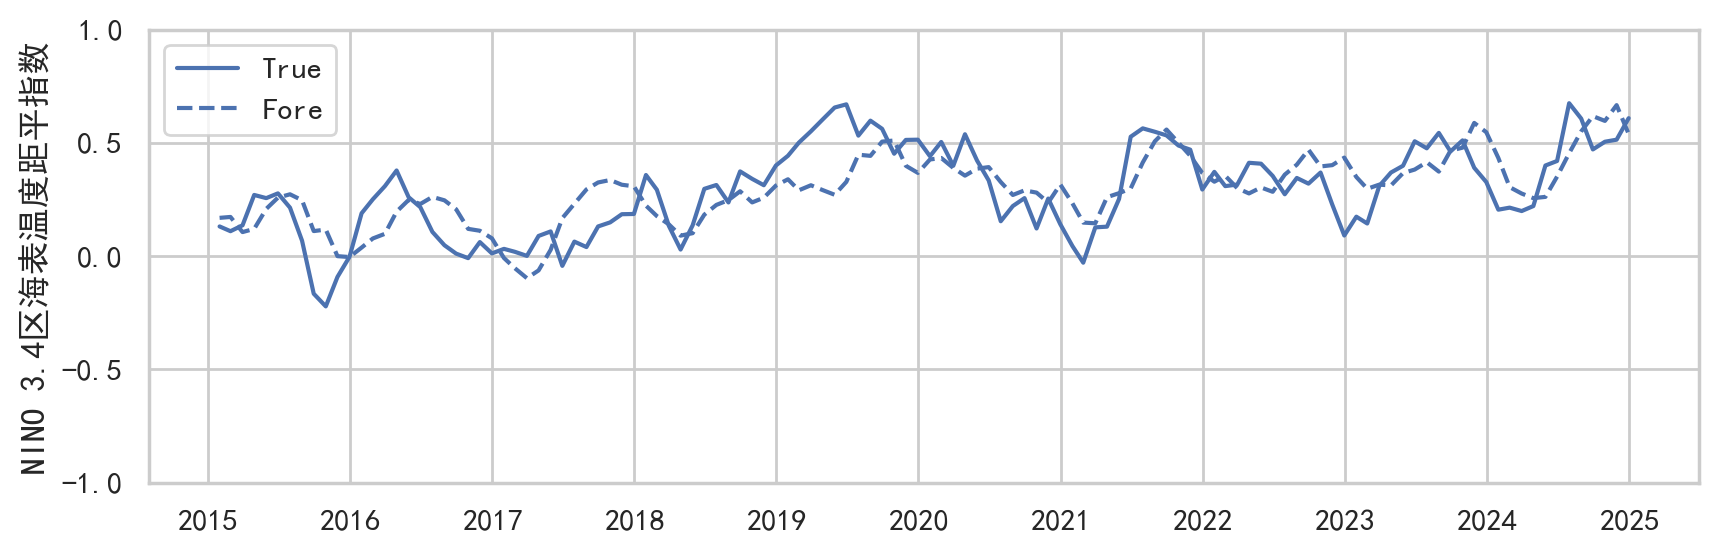

In [18]:
draw_test(y_test, test_predict)

#### 绘制参数地图

In [19]:
import math
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def draw_basemap(ax, extent=None, coastline = None, gridline=None, show_gridline = None, ocean=False, river=True):
    
    crs = ax.projection

    if extent: # border of map
        ax.set_extent(extent, crs=crs)
        
    if coastline:
        ax.coastlines(zorder=3) #draw coastline

    if river:
        ax.add_feature(cfeature.LAKES)
        ax.add_feature(cfeature.RIVERS)

    if ocean:
        ax.add_feature(cfeature.OCEAN)

    if gridline: # interval of lat&lon
        x0, x1, y0, y1 = extent
        if show_gridline:
            ax.gridlines(ylocs=range(-90, 91, gridline), xlocs=range(-180, 181, gridline))
        x0 = math.ceil(x0 // gridline) * gridline
        x1 = math.floor(x1 // gridline) * gridline
        y0 = math.ceil(y0 // gridline) * gridline
        y1 = math.floor(y1 // gridline) * gridline
        ax.set_xticks(range(x0, x1+1, 2 * gridline), crs=crs)
        ax.set_yticks(range(y0, y1+1, gridline), crs=crs)

        lon_formatter = LongitudeFormatter(zero_direction_label=True)
        lat_formatter = LatitudeFormatter()
        ax.xaxis.set_major_formatter(lon_formatter)
        ax.yaxis.set_major_formatter(lat_formatter)
        
        ax.tick_params(labelsize=9) # 设置tick lable为9磅

In [20]:
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator

def draw_pixel(ax, amap, lats, lons, cmap='coolwarm', vmin=None, vmax=None):
    
    crs = ax.projection
    cf  = plt.pcolormesh(lons, lats, amap, transform=crs, cmap=cmap, vmin=vmin, vmax=vmax)
    
    return cf

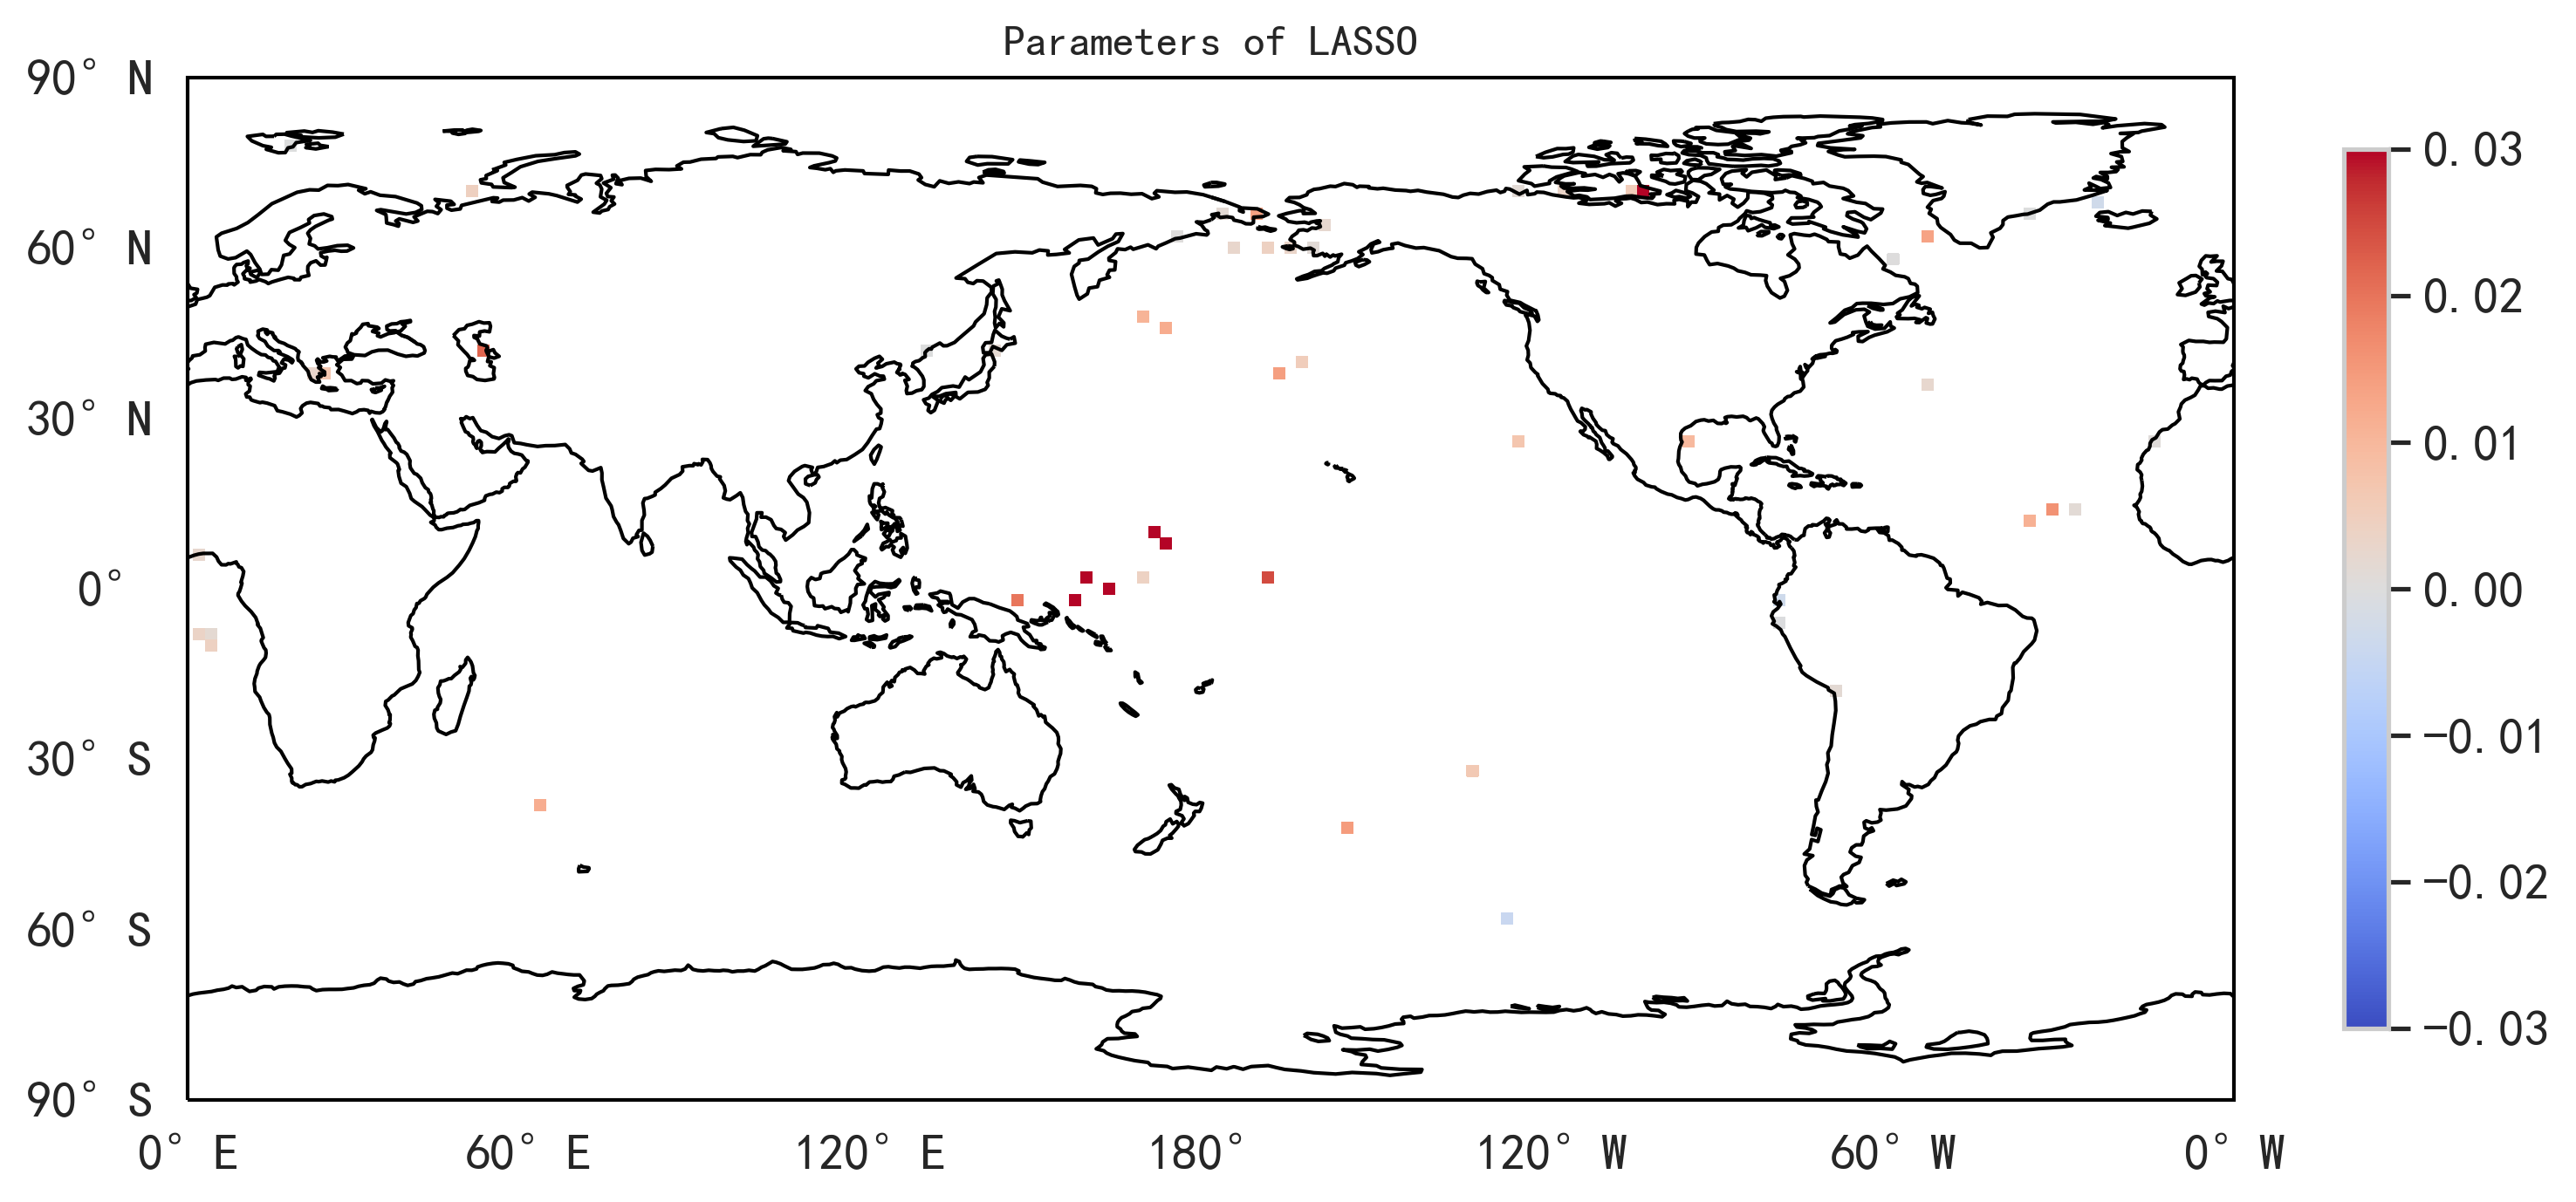

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

extent = [-180, 180, -90, 90] # 真实的地图为[0, 360, -90, 90]，但是因为坐标系向东移了180°，所以各点对应的坐标值向西移了180°

crs = ccrs.PlateCarree(central_longitude=180) # 默认的地图是以本初子午线为中轴，180°W从西到东到180°E，这里改为以180°为中心

# 设置画布大小和分辨率
plt.figure(figsize=(10, 6), dpi=300)

ax = plt.axes(projection=crs)

#绘制底图
draw_basemap(ax, extent, gridline=30, river=False, coastline=True)

lats = np.arange(89, -91, -2) # 89°N到89°S
lons = np.arange(-181, 181, 2) # 其实是(-1, 361)，即0°E到360°E(0°向东到0°)

#绘制contourf
map_coef = np.zeros((89, 180))
coef = np.copy(reg.coef_)
map_coef[A[0]] = coef
map_coef[map_coef==0] = np.nan

cf = draw_pixel(ax, map_coef, lats, lons, cmap='coolwarm', vmin=-0.03, vmax=0.03)

#绘制colorbar
clb = plt.colorbar(aspect=20, fraction=0.02, pad=0.05)
clb.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.title('Parameters of LASSO')

plt.tight_layout()
plt.show()
plt.close()